# Room Temperature Time Series Prediction

In [338]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [339]:
# Load dataset
ro_data = pd.read_pickle("ro_data.pkl")
ro_data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41,NaT,False,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1


In [340]:
ro_data.dtypes

Date                             object
Time                             object
S1_Temp                         float64
S2_Temp                         float64
S3_Temp                         float64
S4_Temp                         float64
S1_Light                          int64
S2_Light                          int64
S3_Light                          int64
S4_Light                          int64
S1_Sound                        float64
S2_Sound                        float64
S3_Sound                        float64
S4_Sound                        float64
S5_CO2                            int64
S5_CO2_Slope                    float64
S6_PIR                            int64
S7_PIR                            int64
Room_Occupancy_Count              int64
Datetime                 datetime64[ns]
time_diff               timedelta64[ns]
is_large_gap                       bool
group                             int64
dtype: object

## Feature Engineering

In [341]:
# Function to create lag features within each group
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df.groupby('group')[column].shift(lag)
    return df

# Function to create rolling features within each group
def create_rolling_features(df, column, window):
    df[f'{column}_rolling_mean_{window}'] = df.groupby('group')[column].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'{column}_rolling_std_{window}'] = df.groupby('group')[column].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)
    return df

# Apply lag features (1 to 3 previous time steps)
ro_data = create_lag_features(ro_data, lags=[1, 2, 3, 4, 5], column='S1_Temp')

# Apply rolling statistics (window = 3 for smoothing)
ro_data = create_rolling_features(ro_data, column='S1_Temp', window=5)

# Create differencing feature within each group
ro_data['S1_Temp_diff_1'] = ro_data.groupby('group')['S1_Temp'].diff(1)

# Drop rows with NaN values (only within each session boundary)
ro_data = ro_data.dropna().reset_index(drop=True)
ro_data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,is_large_gap,group,S1_Temp_lag_1,S1_Temp_lag_2,S1_Temp_lag_3,S1_Temp_lag_4,S1_Temp_lag_5,S1_Temp_rolling_mean_5,S1_Temp_rolling_std_5,S1_Temp_diff_1
0,2017/12/22,10:52:14,25.0,24.81,24.56,25.44,121,34,54,40,...,False,1,25.0,25.0,25.0,24.94,24.94,24.988,0.026833,0.0
1,2017/12/22,10:52:45,25.0,24.75,24.56,25.44,120,34,54,40,...,False,1,25.0,25.0,25.0,25.00,24.94,25.000,0.000000,0.0
2,2017/12/22,10:53:15,25.0,24.81,24.56,25.44,121,34,54,41,...,False,1,25.0,25.0,25.0,25.00,25.00,25.000,0.000000,0.0
3,2017/12/22,10:53:46,25.0,24.81,24.56,25.50,122,35,56,43,...,False,1,25.0,25.0,25.0,25.00,25.00,25.000,0.000000,0.0
4,2017/12/22,10:54:17,25.0,24.81,24.56,25.50,101,34,57,43,...,False,1,25.0,25.0,25.0,25.00,25.00,25.000,0.000000,0.0


## Train/Test split

In [342]:
# Features selected based on correlation analysis in eda-data-clean.ipynb notebook and engineered features
features = [
    'S1_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
    'S1_Temp_lag_1', 'S1_Temp_lag_2', 'S1_Temp_lag_3', 'S1_Temp_lag_4', 'S1_Temp_lag_5',
    'S1_Temp_rolling_mean_5', 'S1_Temp_rolling_std_5', 'S1_Temp_diff_1'
]

target = 'S1_Temp'

# Using the second half of group 1 as testing data because it has a good distribution of occupancy counts
# Training data will include the first half of group 1, all of group 2+3
group_1_data = ro_data[ro_data['group'] == 1]
split_index = len(group_1_data) // 2

train_data = pd.concat([ro_data[ro_data['group'] != 1], group_1_data.iloc[:split_index]])
test_data = group_1_data.iloc[split_index:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

## XGBoost Model

In [343]:
def evaluate_xgb_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Visual predictions
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Actual S1_Temp", linestyle='dashed', alpha=0.7)
    plt.plot(y_pred, label="Predicted S1_Temp", linestyle='dashed', alpha=0.7)
    plt.xlabel("Time Step (Test Set)")
    plt.ylabel("S1_Temp")
    plt.title("XGBoost Predictions vs. Actual Temperature")
    plt.legend()
    plt.show()

    # Calculate scores
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("RMSE: {}".format(rmse))
    print("MAE: {}".format(mae))
    print("R^2 Score: {}".format(r2))

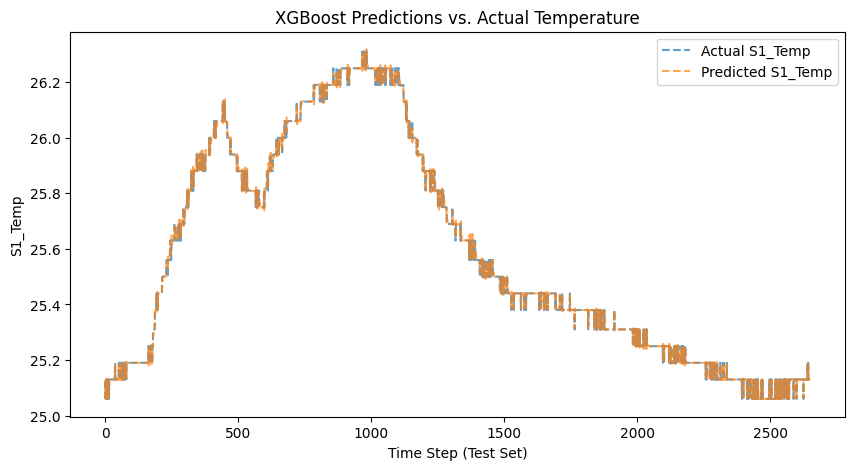

RMSE: 0.006549480677219552
MAE: 0.0034407891615381835
R^2 Score: 0.9997191337669303


In [344]:
# Train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric="rmse")
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

evaluate_xgb_model(xgb_model, X_test, y_test)

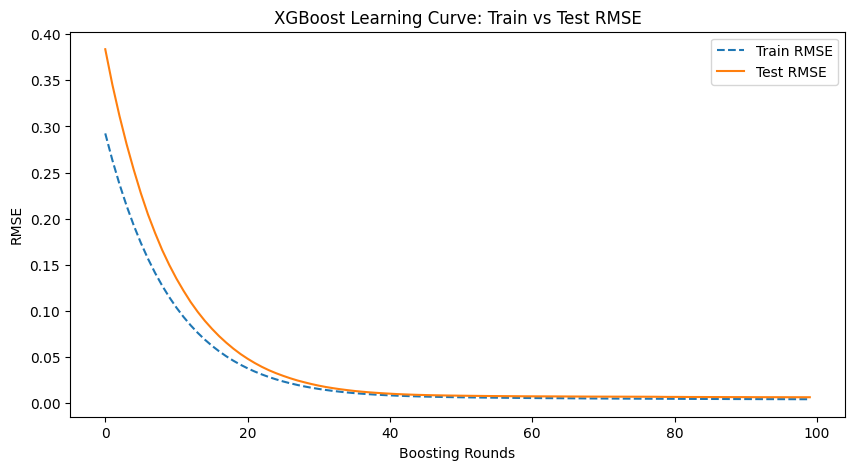

Train RMSE: 0.004390695090384336
Test RMSE: 0.006549480677219552


In [345]:
# The predictions are very close to the actual values on the first attempt
# Comparing train RMSE to test RMSE to check for overfitting

def check_for_overfitting(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate RMSE for train and test sets
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Learning curve plot
    eval_results = model.evals_result()

    plt.figure(figsize=(10, 5))
    plt.plot(eval_results["validation_0"]["rmse"], label="Train RMSE", linestyle="dashed")
    plt.plot(eval_results["validation_1"]["rmse"], label="Test RMSE", linestyle="solid")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("RMSE")
    plt.title("XGBoost Learning Curve: Train vs Test RMSE")
    plt.legend()
    plt.show()

    print("Train RMSE: {}".format(train_rmse))
    print("Test RMSE: {}".format(test_rmse))

check_for_overfitting(xgb_model, X_train, X_test, y_train, y_test)

***The RMSE curves do not indicate overfitting***

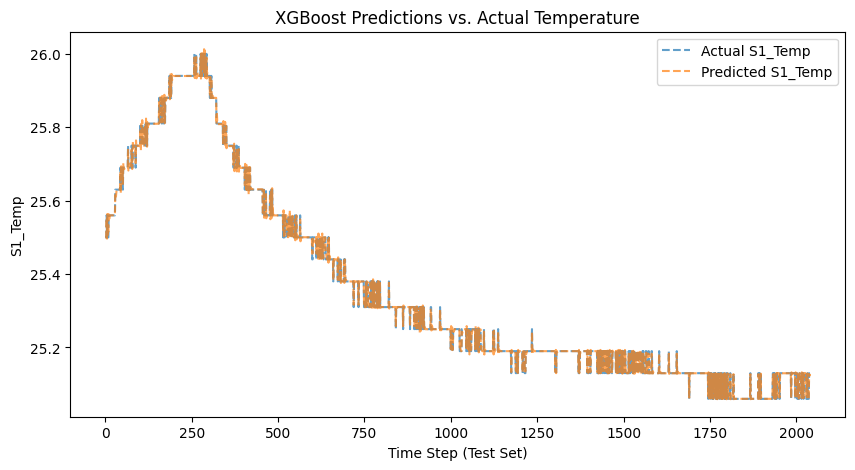

RMSE: 0.004483792915916468
MAE: 0.0023222050760309102
R^2 Score: 0.9997165948023811


In [346]:
# Trying out a different train/test split to see if I can still get accurate predictions

# Using groups 1 and 2 as train data, and group 3 as test data
train_data = ro_data[ro_data['group'].isin([1, 2])]  # Train on groups 1 & 2
test_data = ro_data[ro_data['group'] == 3]  # Test on group 3

# Define features and target
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Train a new XGBoost model with the new split
xgb_model_new_split = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3)
xgb_model_new_split.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

evaluate_xgb_model(xgb_model, X_test, y_test)

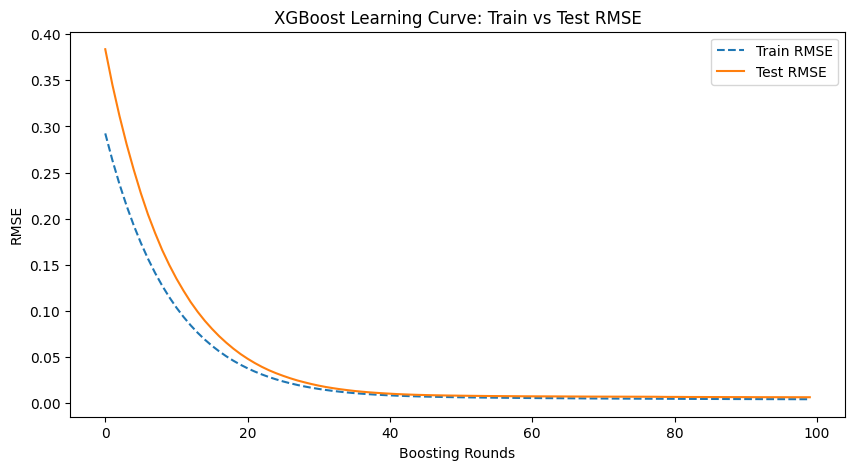

Train RMSE: 0.005178904036648933
Test RMSE: 0.004483792915916468


In [347]:
check_for_overfitting(xgb_model, X_train, X_test, y_train, y_test)

In [348]:
# Get feature importance from the trained XGBoost model
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model_new_split.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
15,S1_Temp_rolling_mean_5,0.975584
10,S1_Temp_lag_1,0.012836
9,Room_Occupancy_Count,0.005192
17,S1_Temp_diff_1,0.003433
0,S1_Light,0.001993
16,S1_Temp_rolling_std_5,0.000509
5,S5_CO2,0.000328
6,S5_CO2_Slope,0.000125
4,S4_Sound,0.000000
7,S6_PIR,0.000000


It looks like the most important feature for predicting room temperature is simply the 5 timestep rolling mean of temperature. Room occupancy was of very little importance. Light near the sensor and CO2 levels had a slight impact as well which makes sense. It would be intereseting to have data from different times of the year to see how that may help predict room temperature.